In [ ]:
import pandas as pd
import numpy as np
import json
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import string
from nltk.tokenize import word_tokenize
import nltk
import scipy.sparse as sp
ds = pd.read_csv("../data/processed/wikipedia_m.csv")
df_big = pd.read_csv("../data/raw/wikipedia_science_chunked_small_rag_512.csv")
df_small = df_big.sample(n=1000, random_state=42122)
df_small

In [9]:
from collections import defaultdict


def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stopwords]
    # Stem the tokens
    stemmer = nltk.PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)



def compute_category_frequency(terms, categories, tfidf_vectorizer, df_sample):
    """
    Compute Category Frequency (CF) for all terms in TF-IDF vectorizer.

    Args:
        terms: List of terms from the TF-IDF vectorizer.
        categories: Encoded category labels.
        tfidf_vectorizer: Trained TfidfVectorizer fit on text data.
        df_sample: Original DataFrame with 'text' and 'category'.

    Returns:
        dict: {term: CF value}.
    """
    num_categories = len(set(categories))  # Total number of unique categories
    category_term_counts = defaultdict(set)  # {term: {categories where it appears}}

    for idx, text in enumerate(df_sample['text']):
        cat = categories[idx]
        tokens = set(tfidf_vectorizer.build_tokenizer()(text))  # Tokenize text
        for token in tokens:
            if token in terms:
                category_term_counts[token].add(cat)

    # Compute CF for each term
    cf = {}
    for term, category_set in category_term_counts.items():
        num_categories_with_term = len(category_set)
        cf[term] = np.log((1 + num_categories) / (1 + num_categories_with_term))

    return cf

def compute_tf_idf_cf_matrix(tfidf_matrix, terms, cf_weights):
    """
    Compute the adjusted TF-IDF-CF matrix.

    Args:
        tfidf_matrix (scipy.sparse.csr_matrix): Initial TF-IDF matrix.
        terms (list): List of terms as per TfidfVectorizer.
        cf_weights (dict): Category Frequency (CF) weight for each term.

    Returns:
        np.ndarray: Adjusted TF-IDF-CF matrix.
    """
    tfidf_cf_matrix = tfidf_matrix.copy()  # Start with original TF-IDF

    for term_idx, term in enumerate(terms):
        tfidf_cf_matrix[:, term_idx] = tfidf_cf_matrix[:, term_idx]* cf_weights.get(term, 1)

    return tfidf_cf_matrix

def build_tf_idf_cf(df_sample: pd.DataFrame):
    # Encode categories
    df_sample['category_encoded'] = df_sample['category'].astype('category').cat.codes
    category_dict = {category: i for i, category in enumerate(df_sample['category'].astype('category').cat.categories)}
    categories = df_sample['category_encoded'].values

    # Preprocess text
    X = df_sample['text'].apply(preprocess_text) 

    # Initialize TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1, 2))
    tfidf_matrix = tfidf_vectorizer.fit_transform(X)  # Sparse TF-IDF matrix
    
    terms = tfidf_vectorizer.get_feature_names_out()  # Vocabulary/terms

    # Compute Category Frequency (CF)
    cf_weights = compute_category_frequency(terms, categories, tfidf_vectorizer, df_sample)

    # Compute TF-IDF-CF Matrix
    tfidf_cf_matrix = compute_tf_idf_cf_matrix(tfidf_matrix, terms, cf_weights)

    return tfidf_cf_matrix, categories, tfidf_vectorizer, cf_weights, category_dict

def get_tfidfcf_embedding(data:pd.DataFrame,tfidf_vectorizer:TfidfVectorizer,cf_weights,text_column:str='text'):
    X = data[text_column].apply(preprocess_text) 
    tfidf_matrix = tfidf_vectorizer.transform(X)  # Sparse TF-IDF matrix
    terms = tfidf_vectorizer.get_feature_names_out()
    tfidf_cf_matrix = compute_tf_idf_cf_matrix(tfidf_matrix, terms, cf_weights)
    return tfidf_cf_matrix

def encode_category(dfff:pd.DataFrame,category_dict:dict,label_column:str='category')->list:
    dfff['category_encoded'] = dfff[label_column].map(category_dict)
    return dfff['category_encoded'].tolist()

In [14]:
# Call the function with your dataframe
tfidf_cf_matrix, y, tfidf_vectorizer, cf_weights, category_dict = build_tf_idf_cf(ds)

In [18]:
ds["category_encoded"]= encode_category(ds,category_dict)

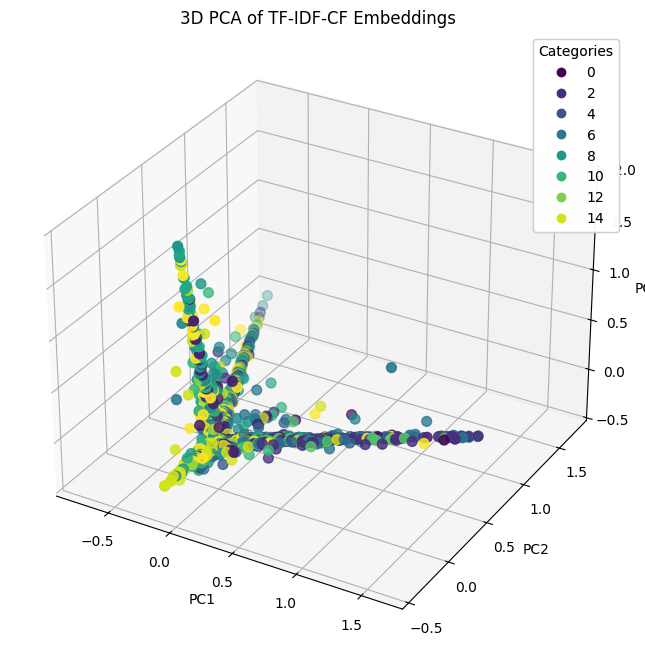

In [20]:
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib import pyplot as plt

# Reduce to 3 components for 3D visualization
pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(tfidf_cf_matrix)

# Create a DataFrame for the 3D PCA results
pca_df = pd.DataFrame(data=pca_result_3d, columns=['PC1', 'PC2', 'PC3'])
pca_df['category_encoded'] = ds['category_encoded']

# Visualize the reduced embeddings in 3D space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['category_encoded'], cmap='viridis', s=50)
legend1 = ax.legend(*scatter.legend_elements(), title="Categories")
ax.add_artist(legend1)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D PCA of TF-IDF-CF Embeddings')
plt.show()


In [146]:
def save(_df_sample,matrix,path="../data/embeddings/tfidfcf_wikipedia_xs_embedding.csv"):
    _df_sample["embeddings"] = matrix.toarray().tolist()
    _df_sample["embeddings"] = _df_sample["embeddings"].apply(lambda x: json.dumps(x))
    _df_sample.to_csv(path, index=False)
    
def load(path="../data/embeddings/tfidfcf_wikipedia_xs_embedding.csv"):
    df_new=pd.read_csv(path)
    df_new["embeddings"] = df_new["embeddings"].apply(lambda x: np.array(json.loads(x))) 
    X_embed = np.stack(np.array(df_new["embeddings"]))
    y_embed = df_new['category_encoded']
    X_train, X_test, y_train, y_test = train_test_split(X_embed, y_embed, test_size=0.2, random_state=412)
    return X_train, X_test, y_train, y_test

In [147]:
save(ds,tfidf_cf_matrix,path="../data/embeddings/tfidfcf_wikipedia_m_embedding.csv")

In [ ]:
# Initialize and train the XGBoost model
def train_model(X_train, X_test, y_train, y_test):
    xgb_model = XGBClassifier(use_label_encoder=False, 
                              eval_metric='mlogloss', 
                              objective='multi:softmax', 
                              num_class=16,
                              learning_rate=0.1, 
                              max_depth=5, 
                              n_estimators=200,
                              gemma=1
                              )

    # Train the XGBoost model with early stopping on the validation set
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
    return xgb_model

from sklearn.metrics import classification_report

def evaluate(_X_test:np.array, _y_test:list, xgb_model):
    _y_pred = xgb_model.predict(_X_test)
    accuracy = accuracy_score(_y_test, _y_pred)
    print(f"Accuracy: {accuracy}")
    print("Classification Report:\n",classification_report(_y_test, _y_pred)) 
    return accuracy

# Extract epoch-wise metrics
def visualize_model(xgb_model):
    from matplotlib import pyplot as plt
    results = xgb_model.evals_result_  # Get the evaluation results during training

    # Print results keys
    print("Keys in evals_result_:", results.keys())
    # Accessing specific metrics
    validation_loss = results['validation_0']['mlogloss']  # Epoch-wise loss on validation set
    epochs = range(1, len(validation_loss) + 1)  # Epoch numbers
    # Plot the loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
    plt.title('Validation Loss Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [176]:
X_train, X_test, y_train, y_test = load("../data/embeddings/tfidfcf_wikipedia_m_embedding.csv")
xgb_model = train_model(X_train, X_test, y_train, y_test)

[0]	validation_0-mlogloss:2.69764


/Users/ngumus/projects/Master-Thesis/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:16:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "gemma", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-mlogloss:2.63972
[2]	validation_0-mlogloss:2.59309
[3]	validation_0-mlogloss:2.55396
[4]	validation_0-mlogloss:2.51944
[5]	validation_0-mlogloss:2.48992
[6]	validation_0-mlogloss:2.46419
[7]	validation_0-mlogloss:2.43994
[8]	validation_0-mlogloss:2.41812
[9]	validation_0-mlogloss:2.39967
[10]	validation_0-mlogloss:2.38252
[11]	validation_0-mlogloss:2.36702
[12]	validation_0-mlogloss:2.35197
[13]	validation_0-mlogloss:2.33896
[14]	validation_0-mlogloss:2.32728
[15]	validation_0-mlogloss:2.31582
[16]	validation_0-mlogloss:2.30528
[17]	validation_0-mlogloss:2.29523
[18]	validation_0-mlogloss:2.28597
[19]	validation_0-mlogloss:2.27779
[20]	validation_0-mlogloss:2.27084
[21]	validation_0-mlogloss:2.26361
[22]	validation_0-mlogloss:2.25605
[23]	validation_0-mlogloss:2.24922
[24]	validation_0-mlogloss:2.24359
[25]	validation_0-mlogloss:2.23827
[26]	validation_0-mlogloss:2.23271
[27]	validation_0-mlogloss:2.22756
[28]	validation_0-mlogloss:2.22249
[29]	validation_0-mlogloss:2.

Accuracy: 0.3259375
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.27      0.31       134
           1       0.37      0.32      0.34       181
           2       0.42      0.49      0.45       207
           3       0.43      0.33      0.37       167
           4       0.36      0.38      0.37       105
           5       0.36      0.30      0.33       126
           6       0.27      0.30      0.28       329
           7       0.23      0.16      0.19       253
           8       0.21      0.12      0.16       289
           9       0.34      0.35      0.34       173
          10       0.42      0.60      0.50       259
          11       0.29      0.15      0.20        68
          12       0.33      0.12      0.18        41
          13       0.35      0.22      0.27       132
          14       0.40      0.50      0.44       365
          15       0.19      0.26      0.22       371

    accuracy                        

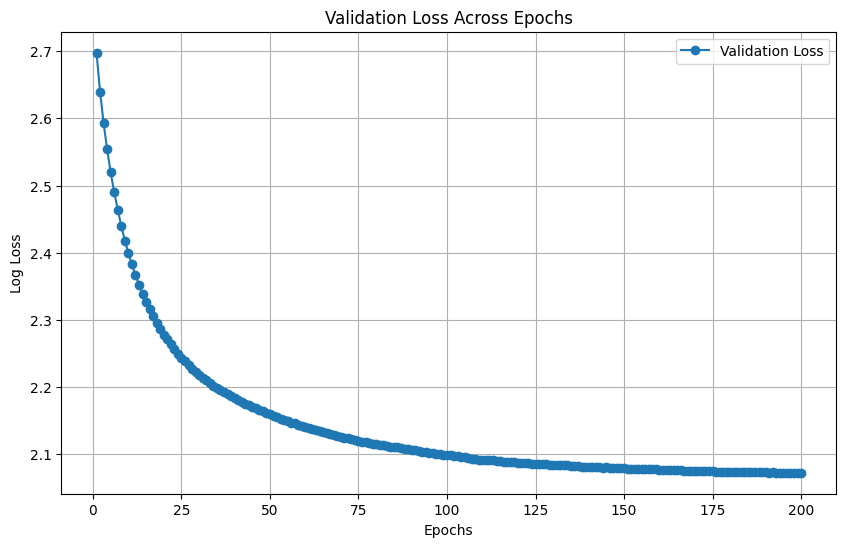

In [177]:
evaluate(X_test, y_test, xgb_model)
visualize_model(xgb_model)

In [178]:
import random
_df = df_big.sample(n=1000, random_state=random.randint(0, 100000))
X_embed = get_tfidfcf_embedding(_df,tfidf_vectorizer,cf_weights)
y_embed = encode_category(_df,category_dict)

In [179]:
y_embed

[3,
 0,
 6,
 0,
 7,
 2,
 15,
 8,
 0,
 3,
 1,
 11,
 15,
 3,
 6,
 10,
 14,
 3,
 10,
 0,
 6,
 13,
 15,
 2,
 1,
 6,
 13,
 14,
 14,
 5,
 14,
 14,
 15,
 6,
 14,
 11,
 15,
 11,
 1,
 4,
 3,
 0,
 14,
 7,
 15,
 5,
 15,
 13,
 0,
 3,
 6,
 2,
 15,
 7,
 15,
 14,
 3,
 6,
 2,
 1,
 2,
 7,
 6,
 6,
 13,
 3,
 10,
 6,
 9,
 5,
 5,
 10,
 8,
 10,
 2,
 6,
 10,
 8,
 0,
 1,
 10,
 7,
 4,
 9,
 8,
 3,
 7,
 14,
 1,
 7,
 11,
 6,
 7,
 4,
 11,
 14,
 7,
 10,
 3,
 8,
 4,
 7,
 10,
 6,
 6,
 5,
 15,
 9,
 9,
 6,
 14,
 0,
 5,
 8,
 8,
 6,
 15,
 6,
 15,
 10,
 3,
 11,
 14,
 9,
 1,
 14,
 3,
 0,
 14,
 7,
 4,
 4,
 8,
 9,
 6,
 1,
 9,
 7,
 5,
 14,
 5,
 7,
 8,
 15,
 0,
 10,
 4,
 8,
 5,
 5,
 1,
 8,
 7,
 10,
 9,
 15,
 0,
 1,
 2,
 10,
 13,
 13,
 8,
 11,
 11,
 3,
 14,
 1,
 14,
 4,
 8,
 9,
 13,
 8,
 2,
 14,
 10,
 7,
 15,
 10,
 6,
 4,
 15,
 1,
 3,
 5,
 15,
 4,
 5,
 7,
 4,
 2,
 4,
 13,
 10,
 10,
 14,
 10,
 12,
 10,
 5,
 14,
 6,
 1,
 14,
 7,
 1,
 5,
 3,
 0,
 14,
 11,
 15,
 8,
 2,
 1,
 15,
 13,
 1,
 13,
 11,
 6,
 8,
 10,
 8,
 7,
 1,
 5,
 10,
 

In [181]:
evaluate(X_embed, y_embed, xgb_model)

Accuracy: 0.341
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.23      0.26        44
           1       0.42      0.44      0.43        57
           2       0.47      0.53      0.50        64
           3       0.45      0.34      0.39        61
           4       0.47      0.44      0.46        36
           5       0.34      0.24      0.29        45
           6       0.23      0.29      0.26        89
           7       0.31      0.22      0.26        76
           8       0.20      0.14      0.16        80
           9       0.32      0.32      0.32        57
          10       0.48      0.63      0.54        86
          11       0.60      0.11      0.18        28
          12       0.00      0.00      0.00        11
          13       0.34      0.25      0.29        44
          14       0.40      0.48      0.44       108
          15       0.20      0.28      0.23       114

    accuracy                           0

/Users/ngumus/projects/Master-Thesis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ngumus/projects/Master-Thesis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ngumus/projects/Master-Thesis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

0.341

In [ ]:
chunks = pd.read_csv("../data/raw/wikipedia_science_chunked_small_rag_512.csv",chunksize=1000)
accuracy_scores = []
for chunk in chunks:
    matrix, y = get_embeddings_from_tfidfcf_vectorizer(chunk, matrix, y, vectorizer, category_weights, category_dict)
    accuracy = evaluate(matrix, y, xgb_model)
    accuracy_scores.append(accuracy)
print("Mean Accuracy:", np.mean(accuracy_scores))

In [173]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = load()
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=300, random_state=42,criterion="log_loss")
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

Random Forest Accuracy: 0.9666666666666667


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

X_train, X_test, y_train, y_test = load("../data/embeddings/tfidfcf_wikipedia_m_embedding.csv")
# Example dataset preprocessing (replace with your actual TF-IDF and labels)
# Assuming X_train_tfidf, X_test_tfidf, y_train, y_test are preprocessed
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=300, shuffle=False)  # Shuffle during training
test_loader = DataLoader(test_dataset, batch_size=300, shuffle=False)


# Neural network with dropout for regularization
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Dropout to prevent overfitting
        self.fc5 = nn.Linear(512, output_dim)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        #out = self.dropout(out)
        out = self.fc5(out)
        return out


# Initialize the model, loss function, optimizer, and learning rate scheduler
input_dim = X_train.shape[1]
output_dim = len(y_train.unique())  # Number of classes
print("Input dimensions:", input_dim)
print("Output dimensions:", output_dim)
model = SimpleNN(input_dim, output_dim)
# Xavier initialization function
def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)  # Xavier initialization (uniform)
        nn.init.zeros_(layer.bias)  # Bias initialized to zero

# Apply Xavier initialization to the model
model.apply(initialize_weights)

# Print model to verify initialization
print(model) 

criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Added weight decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)  # Reduce LR every 5 epochs

# Early stopping configuration
early_stopping_patience = 100
best_validation_acc = 0
epochs_no_improve = 0
best_model_state = None

# Track metrics for visualization
train_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Reset gradients
        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    # Check for best validation accuracy
    if val_accuracy > best_validation_acc:
        best_validation_acc = val_accuracy
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # Save the best model
    else:
        epochs_no_improve += 1

    # Print metrics
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if epochs_no_improve >= early_stopping_patience:
        print("Early stopping triggered!")
        break

    # Step the learning rate scheduler
    scheduler.step()

# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Best validation accuracy achieved: {best_validation_acc:.4f}")

# Save the final best model to disk (optional)
torch.save(best_model_state, "best_model.pth")

# --- Visualization of Metrics ---
epochs = range(1, len(train_losses) + 1)

# Plot Training Loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='blue')
plt.title('Training Loss Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot Accuracy (Training vs. Validation)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o', color='green')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='red')
plt.title('Accuracy Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

ValueError: could not determine the shape of object type 'Series'

: 